In [1]:
import pandas as pd
df = pd.read_csv('chinese_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:56:59.963000,VER,1,0 days 00:01:41.528000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:29.650000,...,True,Red Bull Racing,0 days 00:55:18.169000,2024-04-21 07:03:36.842,1,1.0,False,NaN,False,False
1,0 days 00:58:40.066000,VER,1,0 days 00:01:40.103000,2.0,1.0,NaN,NaN,0 days 00:00:26.651000,0 days 00:00:30.091000,...,True,Red Bull Racing,0 days 00:56:59.963000,2024-04-21 07:05:18.636,1,1.0,False,NaN,False,True
2,0 days 01:00:20.560000,VER,1,0 days 00:01:40.494000,3.0,1.0,NaN,NaN,0 days 00:00:27.011000,0 days 00:00:30.190000,...,True,Red Bull Racing,0 days 00:58:40.066000,2024-04-21 07:06:58.739,1,1.0,False,NaN,False,True
3,0 days 01:02:01.133000,VER,1,0 days 00:01:40.573000,4.0,1.0,NaN,NaN,0 days 00:00:26.923000,0 days 00:00:30.187000,...,True,Red Bull Racing,0 days 01:00:20.560000,2024-04-21 07:08:39.233,1,1.0,False,NaN,False,True
4,0 days 01:03:42.052000,VER,1,0 days 00:01:40.919000,5.0,1.0,NaN,NaN,0 days 00:00:27.106000,0 days 00:00:30.299000,...,True,Red Bull Racing,0 days 01:02:01.133000,2024-04-21 07:10:19.806,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,0 days 02:30:21.037000,PIA,81,0 days 00:01:41.602000,52.0,3.0,NaN,NaN,0 days 00:00:27.234000,0 days 00:00:30.555000,...,True,McLaren,0 days 02:28:39.435000,2024-04-21 08:36:58.108,1,8.0,False,NaN,False,True
1028,0 days 02:32:02.508000,PIA,81,0 days 00:01:41.471000,53.0,3.0,NaN,NaN,0 days 00:00:27.208000,0 days 00:00:30.453000,...,True,McLaren,0 days 02:30:21.037000,2024-04-21 08:38:39.710,1,8.0,False,NaN,False,True
1029,0 days 02:33:44.155000,PIA,81,0 days 00:01:41.647000,54.0,3.0,NaN,NaN,0 days 00:00:27.195000,0 days 00:00:30.533000,...,True,McLaren,0 days 02:32:02.508000,2024-04-21 08:40:21.181,1,8.0,False,NaN,False,True
1030,0 days 02:35:25.605000,PIA,81,0 days 00:01:41.450000,55.0,3.0,NaN,NaN,0 days 00:00:27.133000,0 days 00:00:30.322000,...,True,McLaren,0 days 02:33:44.155000,2024-04-21 08:42:02.828,1,8.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [4]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 56  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [5]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              10.0          18.666667   
1    ALO              3              12.0          14.000000   
2    BOT              1              10.0          10.000000   
3    GAS              3              12.0          14.000000   
4    HAM              2              10.0          18.666667   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000          0.410714         0.589286  
1          0.357143          0.428571         0.214286  
2          0.000000          0.450000         0.550000  
3          0.000000          0.517857         0.482143  
4          0.160714          0.214286         0.625000  


In [6]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,9.0,0 days 01:10:57.775000,NaN,MEDIUM,9.0,1.0
1,ALB,10.0,NaN,0 days 01:11:20.952000,MEDIUM,1.0,2.0
2,ALB,23.0,0 days 01:36:39.225000,NaN,MEDIUM,14.0,2.0
3,ALB,24.0,NaN,0 days 01:37:02.741000,HARD,1.0,3.0
4,ALO,11.0,0 days 01:14:10.100000,NaN,MEDIUM,11.0,1.0
...,...,...,...,...,...,...,...
77,ZHO,9.0,NaN,0 days 01:09:44.380000,HARD,1.0,2.0
78,ZHO,23.0,0 days 01:36:44.393000,NaN,HARD,15.0,2.0
79,ZHO,24.0,NaN,0 days 01:37:09.971000,HARD,1.0,3.0
80,ZHO,40.0,0 days 02:10:17.845000,NaN,HARD,17.0,3.0


In [7]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,10.0,18.666667,0.000000,0.410714,0.589286
1,ALO,3,12.0,14.000000,0.357143,0.428571,0.214286
2,BOT,1,10.0,10.000000,0.000000,0.450000,0.550000
3,GAS,3,12.0,14.000000,0.000000,0.517857,0.482143
4,HAM,2,10.0,18.666667,0.160714,0.214286,0.625000
5,HUL,2,9.0,18.666667,0.000000,0.142857,0.857143
6,LEC,1,22.0,28.000000,0.000000,0.375000,0.625000
7,MAG,2,18.0,18.666667,0.000000,0.517857,0.482143
8,NOR,1,23.0,28.000000,0.000000,0.392857,0.607143
9,OCO,2,10.0,18.666667,0.000000,0.160714,0.839286


In [8]:
df = df[df['IsAccurate']]


In [9]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,762


In [10]:
df['Driver'].value_counts()


,count
Driver,
NOR,44
LEC,44
VER,43
PER,42
PIA,42
RUS,42
MAG,42
SAR,42
HUL,42


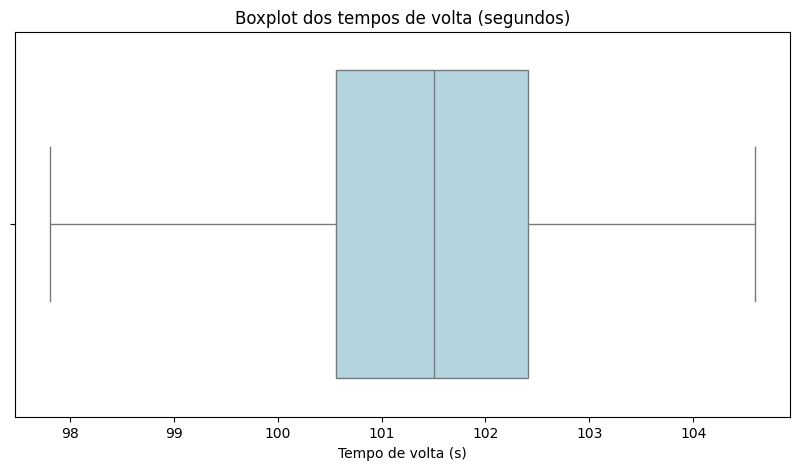

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


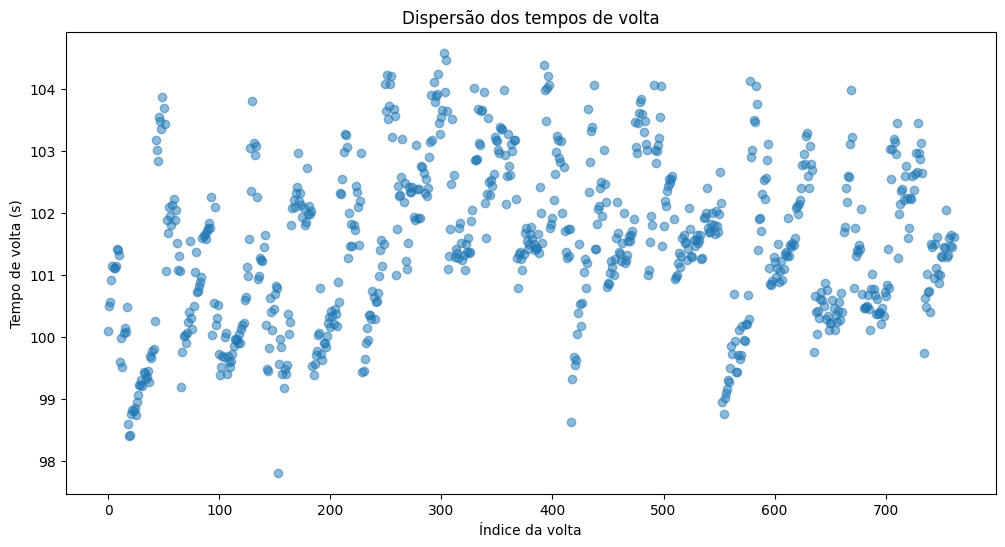

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


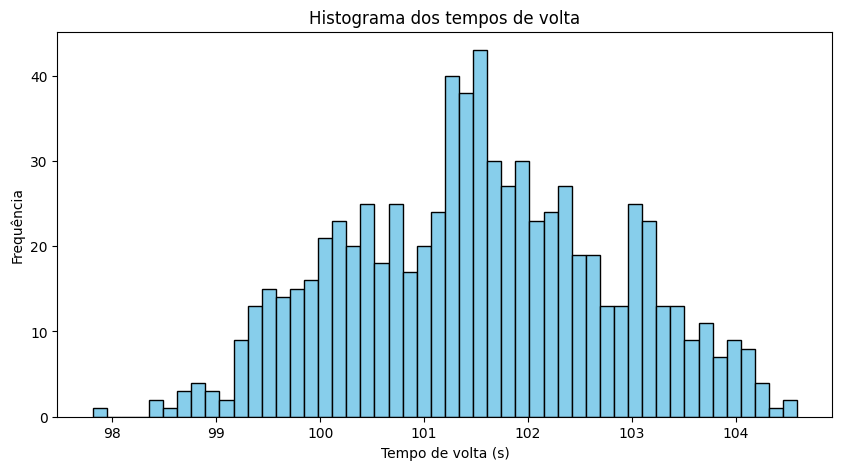

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


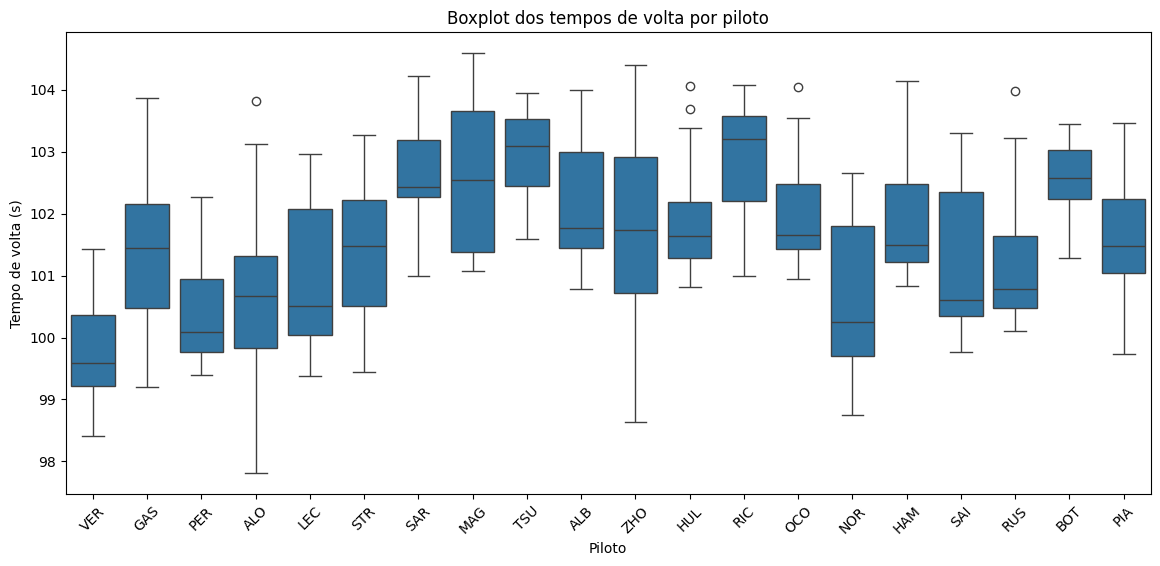

In [14]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [15]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
ALO   0 days 00:01:37.810000
VER   0 days 00:01:38.406000
ZHO   0 days 00:01:38.633000
NOR   0 days 00:01:38.751000
GAS   0 days 00:01:39.198000
LEC   0 days 00:01:39.384000
PER   0 days 00:01:39.388000
STR   0 days 00:01:39.444000
PIA   0 days 00:01:39.739000
SAI   0 days 00:01:39.764000
RUS   0 days 00:01:40.112000
ALB   0 days 00:01:40.790000
HUL   0 days 00:01:40.815000
HAM   0 days 00:01:40.835000
OCO   0 days 00:01:40.937000
RIC   0 days 00:01:40.994000
SAR          0 days 00:01:41
MAG   0 days 00:01:41.077000
BOT   0 days 00:01:41.276000
TSU   0 days 00:01:41.593000
Name: LapTime, dtype: timedelta64[ns]


In [16]:
year = 2024
grand_prix = 'China'
race_date = '2024-04-21'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [17]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,42,102.153714,0.840430,100.790,103.991,101.7655,3.201,2024,China,2024-04-21
1,ALO,40,100.771225,1.293133,97.810,103.817,100.6655,6.007,2024,China,2024-04-21
2,BOT,16,102.586125,0.554597,101.276,103.450,102.5770,2.174,2024,China,2024-04-21
3,GAS,40,101.526425,1.257885,99.198,103.871,101.4475,4.673,2024,China,2024-04-21
4,HAM,42,101.888238,0.941539,100.835,104.135,101.4965,3.300,2024,China,2024-04-21
5,HUL,42,101.854262,0.785317,100.815,104.061,101.6355,3.246,2024,China,2024-04-21
6,LEC,44,100.979159,1.100914,99.384,102.969,100.5105,3.585,2024,China,2024-04-21
7,MAG,42,102.578738,1.162840,101.077,104.590,102.5445,3.513,2024,China,2024-04-21
8,NOR,44,100.646091,1.170865,98.751,102.658,100.2505,3.907,2024,China,2024-04-21
9,OCO,42,101.940357,0.752021,100.937,104.045,101.6515,3.108,2024,China,2024-04-21


In [18]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [19]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,42,102.153714,0.840430,100.790,103.991,101.7655,3.201,2024,China,2024-04-21,56.0,True
1,ALO,40,100.771225,1.293133,97.810,103.817,100.6655,6.007,2024,China,2024-04-21,56.0,True
2,BOT,16,102.586125,0.554597,101.276,103.450,102.5770,2.174,2024,China,2024-04-21,20.0,False
3,GAS,40,101.526425,1.257885,99.198,103.871,101.4475,4.673,2024,China,2024-04-21,56.0,True
4,HAM,42,101.888238,0.941539,100.835,104.135,101.4965,3.300,2024,China,2024-04-21,56.0,True
5,HUL,42,101.854262,0.785317,100.815,104.061,101.6355,3.246,2024,China,2024-04-21,56.0,True
6,LEC,44,100.979159,1.100914,99.384,102.969,100.5105,3.585,2024,China,2024-04-21,56.0,True
7,MAG,42,102.578738,1.162840,101.077,104.590,102.5445,3.513,2024,China,2024-04-21,56.0,True
8,NOR,44,100.646091,1.170865,98.751,102.658,100.2505,3.907,2024,China,2024-04-21,56.0,True
9,OCO,42,101.940357,0.752021,100.937,104.045,101.6515,3.108,2024,China,2024-04-21,56.0,True


In [20]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,10.0,18.666667,0.000000,0.410714,0.589286
1,ALO,3,12.0,14.000000,0.357143,0.428571,0.214286
2,BOT,1,10.0,10.000000,0.000000,0.450000,0.550000
3,GAS,3,12.0,14.000000,0.000000,0.517857,0.482143
4,HAM,2,10.0,18.666667,0.160714,0.214286,0.625000
5,HUL,2,9.0,18.666667,0.000000,0.142857,0.857143
6,LEC,1,22.0,28.000000,0.000000,0.375000,0.625000
7,MAG,2,18.0,18.666667,0.000000,0.517857,0.482143
8,NOR,1,23.0,28.000000,0.000000,0.392857,0.607143
9,OCO,2,10.0,18.666667,0.000000,0.160714,0.839286


In [21]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [22]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,42,102.153714,0.840430,100.790,103.991,101.7655,3.201,2024,China,2024-04-21,56.0,True,2,10.0,18.666667,0.000000,0.410714,0.589286
1,ALO,40,100.771225,1.293133,97.810,103.817,100.6655,6.007,2024,China,2024-04-21,56.0,True,3,12.0,14.000000,0.357143,0.428571,0.214286
2,BOT,16,102.586125,0.554597,101.276,103.450,102.5770,2.174,2024,China,2024-04-21,20.0,False,1,10.0,10.000000,0.000000,0.450000,0.550000
3,GAS,40,101.526425,1.257885,99.198,103.871,101.4475,4.673,2024,China,2024-04-21,56.0,True,3,12.0,14.000000,0.000000,0.517857,0.482143
4,HAM,42,101.888238,0.941539,100.835,104.135,101.4965,3.300,2024,China,2024-04-21,56.0,True,2,10.0,18.666667,0.160714,0.214286,0.625000
5,HUL,42,101.854262,0.785317,100.815,104.061,101.6355,3.246,2024,China,2024-04-21,56.0,True,2,9.0,18.666667,0.000000,0.142857,0.857143
6,LEC,44,100.979159,1.100914,99.384,102.969,100.5105,3.585,2024,China,2024-04-21,56.0,True,1,22.0,28.000000,0.000000,0.375000,0.625000
7,MAG,42,102.578738,1.162840,101.077,104.590,102.5445,3.513,2024,China,2024-04-21,56.0,True,2,18.0,18.666667,0.000000,0.517857,0.482143
8,NOR,44,100.646091,1.170865,98.751,102.658,100.2505,3.907,2024,China,2024-04-21,56.0,True,1,23.0,28.000000,0.000000,0.392857,0.607143
9,OCO,42,101.940357,0.752021,100.937,104.045,101.6515,3.108,2024,China,2024-04-21,56.0,True,2,10.0,18.666667,0.000000,0.160714,0.839286


In [23]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [24]:
df_completo.to_csv('df_completoChina.csv', index=False)
